In [1]:
import sys
sys.path.append('../core')
sys.path.append('/packing/code/core/')

import pack_runner
import pack_ga
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dill
import importlib
from multiprocess import Process, Queue, cpu_count
import kaggle_support as kgs
importlib.reload(pack_runner)

# Configuration
output_dir = '../../results/many_ga/'
os.makedirs(output_dir + 'full/', exist_ok=True)
os.makedirs(output_dir + 'abbr/', exist_ok=True)

fast_mode = False  # Set to True for quick testing
which_runner = pack_runner.baseline_runner  # Which example runner to use
n_parallel_processes = 2 if kgs.env=='local' else 4
print(f"Will use {n_parallel_processes} parallel processes")

vast
stop final relax at some point
Will use 4 parallel processes


In [2]:
# Get git commit ID for tracking
try:
    import git
    repo = git.Repo(search_parent_directories=True)
    git_commit_id = repo.head.object.hexsha
    print(f"Git commit: {git_commit_id[:8]}")
except:
    git_commit_id = 'no_git'
    print("Git not available, using 'no_git' as commit ID")

Git commit: 6c655c80


In [3]:
%load_ext pyinstrument

Detected 1 GPU(s)
Starting parallel execution of 1000 seeds using 4 processes
Staggering process startup by 2 seconds each...

Starting process for seed 1000...
vast
stop final relax at some point
Seed 1000 using GPU 0

=== Starting seed 1000 (Process 10881) ===
{'seed': 1000, 'scale_population': 5.6924716417755645, 'genetic_diversity': np.False_, 'no_jiggle': np.False_, 'bfgs_for_rough': np.False_, 'scale_rough_iterations': 0.2829231482902109, 'scale_fine_iterations': 0.5758831230580473, 'rough_steps': np.int64(0), 'fine_steps': np.int64(1), 'disable_MoveRandomTree': False, 'disable_JiggleTreeSmall': False, 'disable_JiggleTreeBig': False, 'disable_JiggleClusterSmall': False, 'disable_JiggleClusterBig': False, 'disable_Translate': False, 'disable_Twist': True, 'disable_Crossover': False}
Starting process for seed 1001...


/packing/code/analysis/../core/pack_dynamics.py:59: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:89: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 0, Trees 40, Best cost: 0.33922401, Est: 0.84806004, h: 5.786394
vast
Generation 1, Trees 40, Best cost: 0.27974486, Est: 0.69936218, h: 5.261712
Generation 2, Trees 40, Best cost: 0.22526504, Est: 0.56316261, h: 4.717928
Generation 3, Trees 40, Best cost: 0.18333840, Est: 0.45834599, h: 4.253250
stop final relax at some point
Generation 4, Trees 40, Best cost: 0.17170088, Est: 0.42925220, h: 4.118521
Runtime: 4.7s

Seed 1000 completed in 4.7s
Best final costs: [0.17170088]
Modifier values: {'seed': 1000, 'scale_population': 5.6924716417755645, 'genetic_diversity': np.False_, 'no_jiggle': np.False_, 'bfgs_for_rough': np.False_, 'scale_rough_iterations': 0.2829231482902109, 'scale_fine_iterations': 0.5758831230580473, 'rough_steps': np.int64(0), 'fine_steps': np.int64(1), 'disable_MoveRandomTree': False, 'disable_JiggleTreeSmall': False, 'disable_JiggleTreeBig': False, 'disable_JiggleClusterSmall': False, 'disable_JiggleClusterBig': False, 'disable_Translate': False, 'disable

/packing/code/analysis/../core/pack_dynamics.py:59: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:89: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


vast
Generation 0, Trees 40, Best cost: 0.39990512, Est: 0.99976282, h: 6.315602
Generation 1, Trees 40, Best cost: 0.37805969, Est: 0.94514923, h: 6.139912
stop final relax at some point
Generation 2, Trees 40, Best cost: 0.35662800, Est: 0.89157000, h: 5.964693
Seed 1002 using GPU 0

=== Starting seed 1002 (Process 11043) ===
{'seed': 1002, 'scale_population': 4.427390435348043, 'genetic_diversity': np.False_, 'no_jiggle': np.True_, 'bfgs_for_rough': np.False_, 'scale_rough_iterations': 0.45054272719442046, 'scale_fine_iterations': 0.40341806811958303, 'rough_steps': np.int64(1), 'fine_steps': np.int64(1), 'disable_MoveRandomTree': True, 'disable_JiggleTreeSmall': True, 'disable_JiggleTreeBig': False, 'disable_JiggleClusterSmall': False, 'disable_JiggleClusterBig': False, 'disable_Translate': False, 'disable_Twist': False, 'disable_Crossover': False}
Generation 3, Trees 40, Best cost: 0.33651775, Est: 0.84129438, h: 5.791789
Generation 4, Trees 40, Best cost: 0.31770164, Est: 0.79425

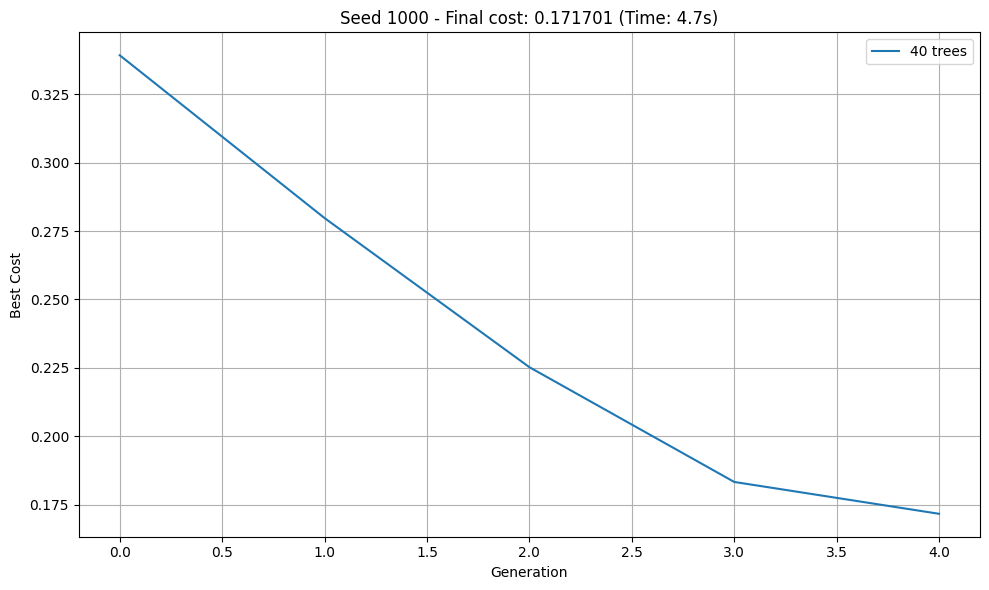


*** Result received for seed 1001: avg_cost = 0.317702, time = 6.0s ***



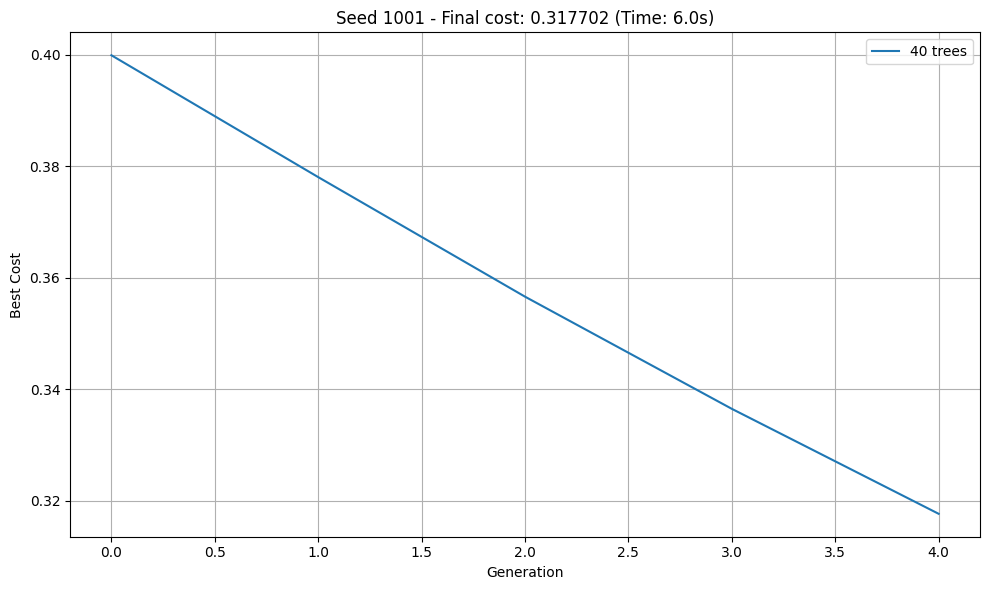

Waiting 4.8s before starting seed 1004...


/packing/code/analysis/../core/pack_dynamics.py:59: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:89: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 0, Trees 40, Best cost: 0.30778983, Est: 0.76947460, h: 5.517062
vast
Generation 1, Trees 40, Best cost: 0.25288495, Est: 0.63221240, h: 4.995198
Generation 2, Trees 40, Best cost: 0.21065156, Est: 0.52662892, h: 4.560163
stop final relax at some point
Generation 3, Trees 40, Best cost: 0.18374802, Est: 0.45937004, h: 4.255228
Seed 1003 using GPU 0

=== Starting seed 1003 (Process 11124) ===
{'seed': 1003, 'scale_population': 2.6898163144177007, 'genetic_diversity': np.False_, 'no_jiggle': np.True_, 'bfgs_for_rough': np.True_, 'scale_rough_iterations': 0.6947124017357668, 'scale_fine_iterations': 0.7769015755084692, 'rough_steps': np.int64(0), 'fine_steps': np.int64(2), 'disable_MoveRandomTree': False, 'disable_JiggleTreeSmall': False, 'disable_JiggleTreeBig': False, 'disable_JiggleClusterSmall': False, 'disable_JiggleClusterBig': False, 'disable_Translate': True, 'disable_Twist': False, 'disable_Crossover': False}
Generation 4, Trees 40, Best cost: 0.17267722, Est: 0.431693

/packing/code/analysis/../core/pack_dynamics.py:59: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:89: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 0, Trees 40, Best cost: 0.33416829, Est: 0.83542070, h: 5.767799
vast
Generation 1, Trees 40, Best cost: 0.24814509, Est: 0.62036271, h: 4.963572
Generation 2, Trees 40, Best cost: 0.19589281, Est: 0.48973203, h: 4.395883
stop final relax at some point
Generation 3, Trees 40, Best cost: 0.18076994, Est: 0.45192485, h: 4.218652
Seed 1004 using GPU 0

=== Starting seed 1004 (Process 11193) ===
{'seed': 1004, 'scale_population': 1.0079240746664353, 'genetic_diversity': np.True_, 'no_jiggle': np.True_, 'bfgs_for_rough': np.True_, 'scale_rough_iterations': 0.4425891732525137, 'scale_fine_iterations': 0.6586064243721889, 'rough_steps': np.int64(0), 'fine_steps': np.int64(3), 'disable_MoveRandomTree': True, 'disable_JiggleTreeSmall': False, 'disable_JiggleTreeBig': False, 'disable_JiggleClusterSmall': False, 'disable_JiggleClusterBig': False, 'disable_Translate': False, 'disable_Twist': True, 'disable_Crossover': False}
Generation 4, Trees 40, Best cost: 0.17131019, Est: 0.42827549

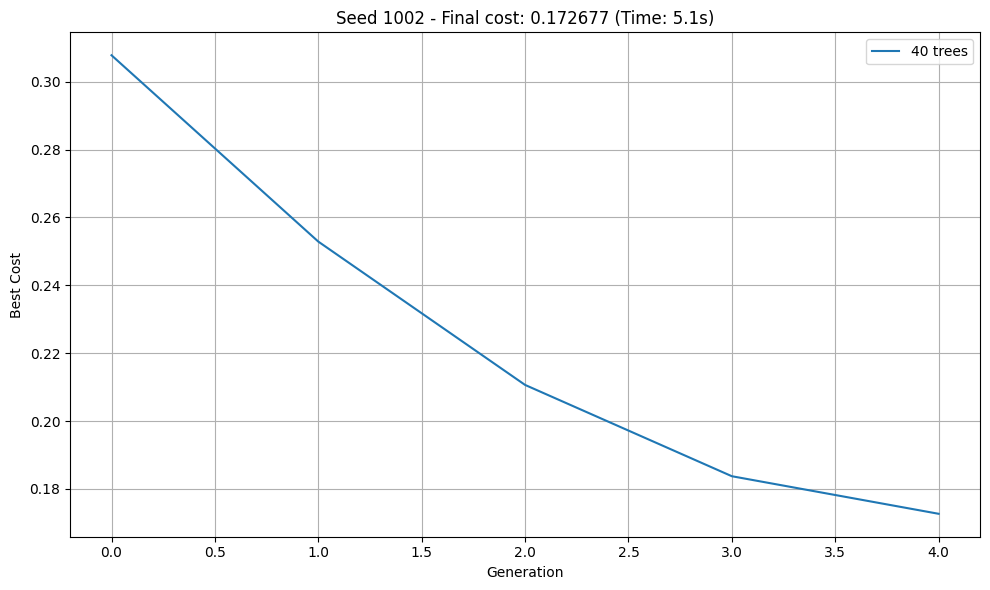


*** Result received for seed 1003: avg_cost = 0.171310, time = 5.5s ***



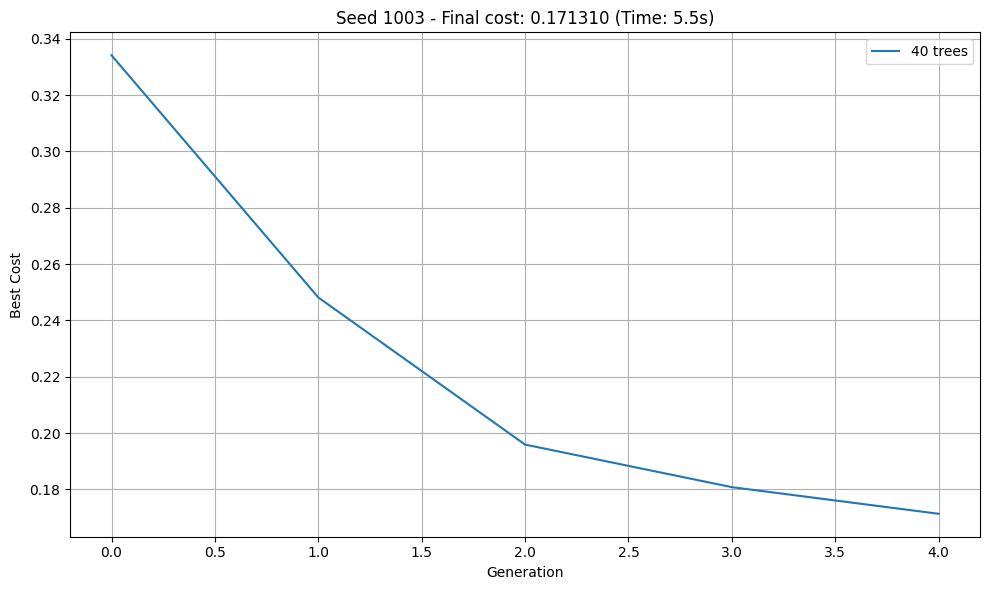

Waiting 4.6s before starting seed 1006...


/packing/code/analysis/../core/pack_dynamics.py:59: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:89: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


vast
Generation 0, Trees 40, Best cost: 0.32845059, Est: 0.82112646, h: 5.716870
Generation 1, Trees 40, Best cost: 0.25463960, Est: 0.63659897, h: 5.033707
stop final relax at some point
Generation 2, Trees 40, Best cost: 0.20296684, Est: 0.50741711, h: 4.480381
Seed 1005 using GPU 0

=== Starting seed 1005 (Process 11273) ===
{'seed': 1005, 'scale_population': 1.7399725576110434, 'genetic_diversity': np.False_, 'no_jiggle': np.False_, 'bfgs_for_rough': np.False_, 'scale_rough_iterations': 0.6747022437584487, 'scale_fine_iterations': 0.8513134520896777, 'rough_steps': np.int64(0), 'fine_steps': np.int64(1), 'disable_MoveRandomTree': True, 'disable_JiggleTreeSmall': False, 'disable_JiggleTreeBig': False, 'disable_JiggleClusterSmall': False, 'disable_JiggleClusterBig': False, 'disable_Translate': True, 'disable_Twist': False, 'disable_Crossover': False}
Generation 3, Trees 40, Best cost: 0.17946024, Est: 0.44865060, h: 4.205374
Generation 4, Trees 40, Best cost: 0.17182392, Est: 0.42955

/packing/code/analysis/../core/pack_dynamics.py:59: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:89: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


vast
Generation 0, Trees 40, Best cost: 0.31672215, Est: 0.79180536, h: 5.601734
Generation 1, Trees 40, Best cost: 0.23114759, Est: 0.57786899, h: 4.775183
Generation 2, Trees 40, Best cost: 0.18765049, Est: 0.46912622, h: 4.306386
stop final relax at some point
Generation 3, Trees 40, Best cost: 0.17460814, Est: 0.43652034, h: 4.135654
Generation 4, Trees 40, Best cost: 0.17080583, Est: 0.42701459, h: 4.093199
Runtime: 4.7s

Seed 1005 completed in 4.7s
Best final costs: [0.17080583]
Modifier values: {'seed': 1005, 'scale_population': 1.7399725576110434, 'genetic_diversity': np.False_, 'no_jiggle': np.False_, 'bfgs_for_rough': np.False_, 'scale_rough_iterations': 0.6747022437584487, 'scale_fine_iterations': 0.8513134520896777, 'rough_steps': np.int64(0), 'fine_steps': np.int64(1), 'disable_MoveRandomTree': True, 'disable_JiggleTreeSmall': False, 'disable_JiggleTreeBig': False, 'disable_JiggleClusterSmall': False, 'disable_JiggleClusterBig': False, 'disable_Translate': True, 'disable_T

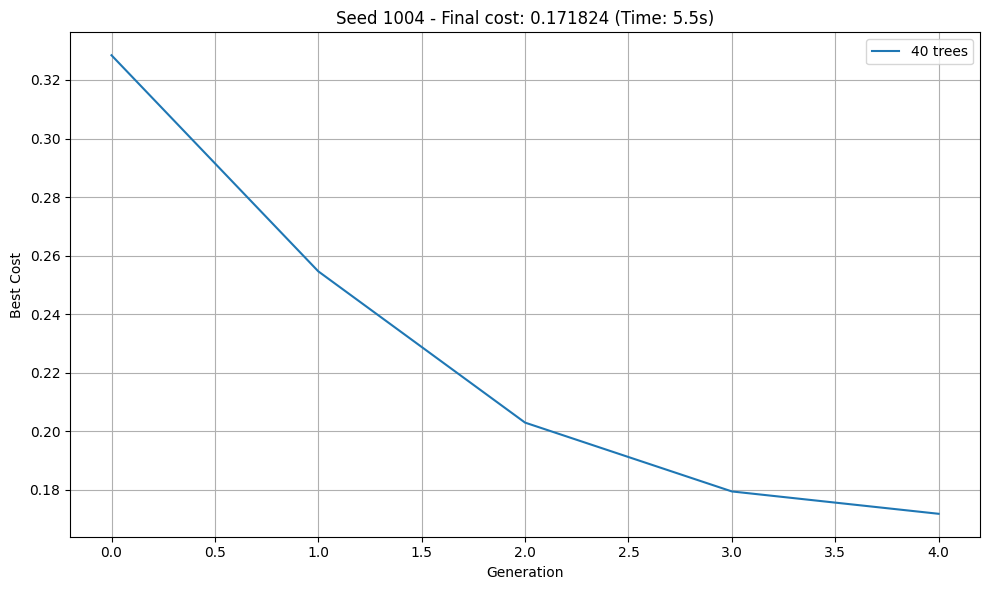


*** Result received for seed 1005: avg_cost = 0.170806, time = 4.7s ***



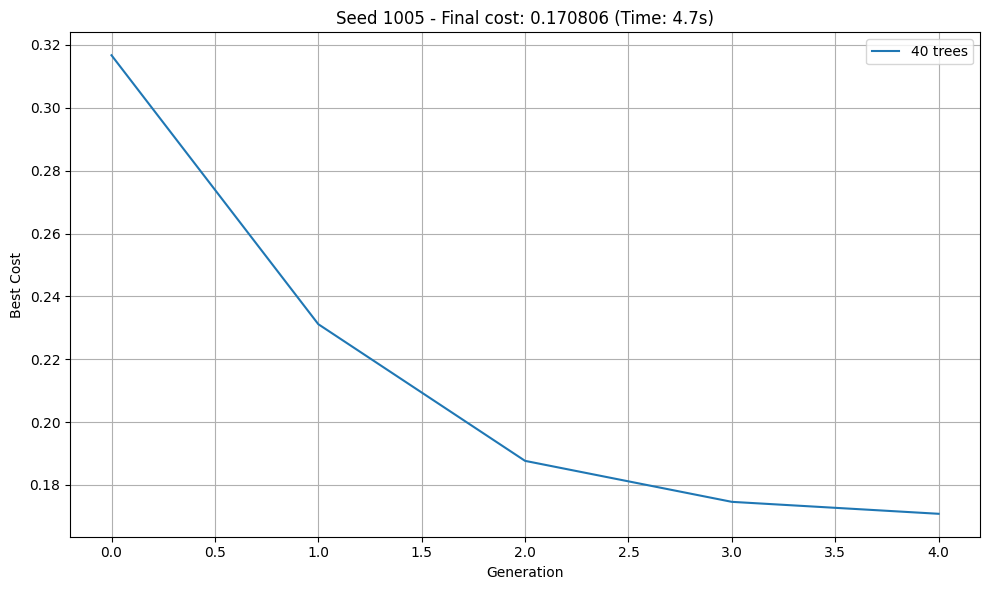

Waiting 4.5s before starting seed 1008...
vast


/packing/code/analysis/../core/pack_dynamics.py:59: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:89: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 0, Trees 40, Best cost: 0.28570905, Est: 0.71427264, h: 5.305182
Generation 1, Trees 40, Best cost: 0.21058339, Est: 0.52645845, h: 4.551041
stop final relax at some point
Generation 2, Trees 40, Best cost: 0.17797701, Est: 0.44494252, h: 4.194172
Seed 1007 using GPU 0

=== Starting seed 1007 (Process 11423) ===
{'seed': 1007, 'scale_population': 1.6410244371479719, 'genetic_diversity': np.False_, 'no_jiggle': np.False_, 'bfgs_for_rough': np.False_, 'scale_rough_iterations': 0.2769357203448836, 'scale_fine_iterations': 0.629936914165003, 'rough_steps': np.int64(1), 'fine_steps': np.int64(1), 'disable_MoveRandomTree': False, 'disable_JiggleTreeSmall': True, 'disable_JiggleTreeBig': False, 'disable_JiggleClusterSmall': True, 'disable_JiggleClusterBig': False, 'disable_Translate': False, 'disable_Twist': False, 'disable_Crossover': False}
Generation 3, Trees 40, Best cost: 0.17027427, Est: 0.42568569, h: 4.099311


In [ ]:
import kaggle_support as kgs
kgs.profiling = False

def run_single_seed(seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue):
    """Worker function to run a single seed in a separate process"""
    # Import everything needed in this worker process
    import sys
    sys.path.append('../core')
    sys.path.append('/packing/code/core/')
    
    import numpy as np
    import time
    import copy
    import os
    import dill
    
    try:
        # Set CUDA device based on process to avoid conflicts
        # This helps if you have multiple GPUs
        try:
            import cupy as cp
            # Use modulo to cycle through available GPUs
            n_gpus = cp.cuda.runtime.getDeviceCount()
            device_id = seed % n_gpus
            cp.cuda.Device(device_id).use()
            # Small delay to stagger CUDA initialization
            time.sleep(0.5)
            print(f'Seed {seed} using GPU {device_id}')
        except Exception as e:
            print(f'Warning: Could not set CUDA device for seed {seed}: {e}')
        
        print(f'\n=== Starting seed {seed} (Process {os.getpid()}) ===')
        
        r = which_runner(fast_mode=fast_mode)
        r.seed = seed
        r.base_ga.N_trees_to_do = np.array([40])
        
        # Check if this experiment already exists
        base_filename = f"{r.label}_{r.seed}_{git_commit_id[:8]}"
        if fast_mode:
            base_filename += '_fast'
        
        # Run the experiment
        start_time = time.time()
        r.run()
        elapsed_time = time.time() - start_time
        
        if r.exception is not None:
            print(f"ERROR occurred in seed {seed}: {r.exception[:200]}")
            result_queue.put({'seed': seed, 'success': False, 'error': r.exception[:200]})
            return
        
        # Get best costs for each N_trees
        best_costs_final = r.best_costs[-1, :]
        print(f"\nSeed {seed} completed in {elapsed_time:.1f}s")
        print(f"Best final costs: {best_costs_final}")
        print(f"Modifier values: {r.modifier_values}")
        
        # Create score string from average best cost
        avg_cost = np.mean(best_costs_final)
        score_str = f"{avg_cost:.4f}".replace('.', '_')
        
        # Save full version (with populations)
        output_file_full = output_dir + 'full/' + base_filename + '_f.pkl'
        with open(output_file_full, 'wb') as f:
            dill.dump(r, f)
        print(f"Saved full: {output_file_full}")
        
        # Save abbreviated version (without full populations to save space)
        r_abbr = copy.deepcopy(r)
        r_abbr.result_ga.populations = []  # Clear populations to save space
        output_file_abbr = output_dir + 'abbr/' + base_filename + '_a.pkl'
        with open(output_file_abbr, 'wb') as f:
            dill.dump(r_abbr, f)
        print(f"Saved abbr: {output_file_abbr}")
        
        # Put result data in queue for plotting
        result_queue.put({
            'seed': seed,
            'success': True,
            'label': r.label,
            'best_costs': r.best_costs.copy(),
            'N_trees_to_do': r.base_ga.N_trees_to_do.copy(),
            'avg_cost': avg_cost,
            'elapsed_time': elapsed_time
        })
        
        print(f"Seed {seed} finished successfully!")
        print(f"{'='*60}")
        
    except Exception as e:
        import traceback
        error_msg = traceback.format_exc()
        print(f"EXCEPTION in seed {seed}:\n{error_msg}")
        result_queue.put({'seed': seed, 'success': False, 'error': str(e)})


# Main parallel execution
n_seeds = 1000
result_queue = Queue()
active_processes = []
completed_results = []
seeds_to_run = [a+1000 for a in list(range(n_seeds))]
next_seed_idx = 0

# Limit parallel processes if using GPU (to avoid memory issues)
# You may want to adjust this based on your GPU memory
import cupy as cp
n_gpus = cp.cuda.runtime.getDeviceCount()
print(f"Detected {n_gpus} GPU(s)")

# Adjust parallel processes - too many can overwhelm GPU memory
# Start with 1-2 processes per GPU, adjust based on your GPU memory
max_parallel = n_parallel_processes
print(f"Starting parallel execution of {n_seeds} seeds using {max_parallel} processes")
print(f"Staggering process startup by 2 seconds each...\n")

# Start initial batch of processes with staggered startup
stagger_delay = 5.0  # seconds between each process start
for i in range(min(max_parallel, n_seeds)):
    seed = seeds_to_run[next_seed_idx]
    print(f"Starting process for seed {seed}...")
    p = Process(target=run_single_seed, args=(seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue))
    p.start()
    active_processes.append((p, seed))
    next_seed_idx += 1
    
    # Stagger the startup to avoid CUDA initialization conflicts
    if i < min(max_parallel, n_seeds) - 1:  # Don't sleep after the last one
        time.sleep(stagger_delay)

print(f"\nAll initial processes started. Monitoring for completion...\n")

# Track when we last started a process to stagger new starts
last_process_start_time = time.time()

# Main loop: wait for processes to complete and start new ones
while active_processes or not result_queue.empty():
    # Check for completed results in queue
    while not result_queue.empty():
        result = result_queue.get()
        completed_results.append(result)
        
        if result['success']:
            print(f"\n*** Result received for seed {result['seed']}: avg_cost = {result['avg_cost']:.6f}, time = {result['elapsed_time']:.1f}s ***\n")
            
            # Plot convergence for this seed immediately
            fig, ax = plt.subplots(figsize=(10, 6))
            for i_tree, n_trees in enumerate(result['N_trees_to_do']):
                ax.plot(result['best_costs'][:, i_tree], label=f'{n_trees} trees')
            ax.set_xlabel('Generation')
            ax.set_ylabel('Best Cost')
            ax.set_title(f"Seed {result['seed']} - Final cost: {result['avg_cost']:.6f} (Time: {result['elapsed_time']:.1f}s)")
            ax.legend()
            ax.grid(True)
            plt.tight_layout()
            plt.show()
            
        else:
            print(f"\n*** Seed {result['seed']} failed: {result.get('error', 'Unknown error')} ***\n")
    
    # Check for finished processes and start new ones
    for i in range(len(active_processes) - 1, -1, -1):
        p, seed = active_processes[i]
        if not p.is_alive():
            p.join()
            active_processes.pop(i)
            
            # Start a new process if there are more seeds to run
            if next_seed_idx < n_seeds:
                new_seed = seeds_to_run[next_seed_idx]
                
                # Stagger new process starts to avoid CUDA conflicts
                time_since_last_start = time.time() - last_process_start_time
                if time_since_last_start < stagger_delay:
                    sleep_time = stagger_delay - time_since_last_start
                    print(f"Waiting {sleep_time:.1f}s before starting seed {new_seed}...")
                    time.sleep(sleep_time)
                
                print(f"Starting process for seed {new_seed}...")
                new_p = Process(target=run_single_seed, args=(new_seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue))
                new_p.start()
                active_processes.append((new_p, new_seed))
                last_process_start_time = time.time()
                next_seed_idx += 1
    
    # Small sleep to avoid busy waiting
    time.sleep(0.1)

print(f"\n{'='*80}")
print(f"All {n_seeds} seeds completed!")
print(f"Successful runs: {sum(1 for r in completed_results if r['success'])}")
print(f"Failed runs: {sum(1 for r in completed_results if not r['success'])}")

# Create summary plots for all successful runs
successful_results = [r for r in completed_results if r['success']]
if successful_results:
    print(f"\nCreating summary plots for {len(successful_results)} successful runs...")
    
    # Plot all convergence curves overlaid
    fig, ax = plt.subplots(figsize=(12, 8))
    for result in successful_results:
        for i_tree, n_trees in enumerate(result['N_trees_to_do']):
            ax.plot(result['best_costs'][:, i_tree], alpha=0.3, linewidth=0.5, color='blue')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Cost')
    ax.set_title(f'GA Convergence - All {len(successful_results)} Runs (Overlaid)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot distribution of final costs
    final_costs = [r['avg_cost'] for r in successful_results]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(final_costs, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(final_costs), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(final_costs):.6f}')
    ax.axvline(np.min(final_costs), color='green', linestyle='--', linewidth=2, label=f'Best: {np.min(final_costs):.6f}')
    ax.set_xlabel('Average Final Cost')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of Final Costs ({len(successful_results)} runs)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Statistics:")
    print(f"  Best cost:  {np.min(final_costs):.6f}")
    print(f"  Worst cost: {np.max(final_costs):.6f}")
    print(f"  Mean cost:  {np.mean(final_costs):.6f}")
    print(f"  Std cost:   {np.std(final_costs):.6f}")
    print(f"  Median cost: {np.median(final_costs):.6f}")


In [ ]:
# Optional: Load and analyze results
results_files = sorted(glob.glob(output_dir + 'abbr/*.pkl'))
print(f"Found {len(results_files)} result files")

if len(results_files) > 0:
    # Load all results
    results = []
    for f in results_files:
        with open(f, 'rb') as fp:
            results.append(dill.load(fp))
    
    # Extract hyperparameters and final costs
    hyperparams = []
    final_costs = []
    
    for r in results:
        if r.exception is None and r.best_costs is not None:
            hyperparams.append(r.modifier_values)
            final_costs.append(np.mean(r.best_costs[-1, :]))  # Average across N_trees
    
    print(f"\nSuccessfully completed runs: {len(final_costs)}")
    if len(final_costs) > 0:
        print(f"Best average cost: {np.min(final_costs):.6f}")
        print(f"Worst average cost: {np.max(final_costs):.6f}")
        print(f"Mean average cost: {np.mean(final_costs):.6f}")
        print(f"Std average cost: {np.std(final_costs):.6f}")
        
        # Plot distribution of final costs
        plt.figure(figsize=(8, 5))
        plt.hist(final_costs, bins=20, edgecolor='black')
        plt.xlabel('Average Final Cost')
        plt.ylabel('Count')
        plt.title('Distribution of Final Costs Across Hyperparameter Settings')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()